### Solving for the WCS using out of focus phosim images (without transpose correction)

In this notebook we solve for a new WCS given a phosim donut image and an assocaited reference catalog (Gaia). This uses the Rubin DM stack and AstrometryTask together with the T&S dount detector code

NOTE: with w_2020_24 the phosim images are read in correctly (ie no transpose is necessary)

TODO
- understand DM detection and centroiding accuracy for donuts

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay

from lsst.ts.wep.bsc.DonutDetector import DonutDetector
from lsst.ts.wep.cwfs.TemplateUtils import createTemplateImage

In [2]:
def makeSourceCat(bbox, distortedWcs, refObjLoader):
    """Make a source catalog by reading the position reference stars and distorting the positions
    """
    loadRes = refObjLoader.loadPixelBox(bbox=bbox, wcs=distortedWcs, filterName="phot_rp_mean")
    refCat = loadRes.refCat
    refIdKey = refCat.schema["id"].asKey()
    refRAKey = refCat.schema["coord_ra"].asKey()
    refDecKey = refCat.schema["coord_dec"].asKey()
    refCentroidKey = afwTable.Point2DKey(refCat.schema["centroid"])
    refFluxRKey = refCat.schema["phot_rp_mean_flux"].asKey()

    sourceSchema = afwTable.SourceTable.makeMinimalSchema()
    measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
    sourceCat = afwTable.SourceCatalog(sourceSchema)
    sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
    sourceIdKey = sourceSchema["id"].asKey()
    sourceRAKey = sourceSchema["coord_ra"].asKey()
    sourceDecKey = sourceSchema["coord_dec"].asKey()
    sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
    sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

    sourceCat.reserve(len(refCat))
    for refObj in refCat:
        src = sourceCat.addNew()
        src.set(sourceIdKey, refObj.get(refIdKey))
        src.set(sourceRAKey, refObj.get(refRAKey))
        src.set(sourceDecKey, refObj.get(refDecKey))

        src.set(sourceCentroidKey, refObj.get(refCentroidKey))
        src.set(sourceInstFluxKey, refObj.get(refFluxRKey))
        src.set(sourceInstFluxErrKey, refObj.get(refFluxRKey)/100)
    return sourceCat

In [3]:
def plotDistances(matches):
    '''Plot histogram of match separations'''
    distances = np.array([match.distance for match in results.matches])
    distances *= 180.*3600./np.pi
    plt.hist(distances)
    plt.xlabel("Distance (arcsecond)")
    plt.ylabel("Number")

In [4]:
#convolution/correlation code for centroids
from lsst.afw.image import Image, Mask, MaskedImage, ImageF, MaskedImageF, ExposureF
from numpy.fft import fft2, ifft2
from scipy.signal import fftconvolve, correlate2d, correlate

def correlateExposureWithImage(exposure, kernelImage, fft=True):
    '''Convolve image and variance planes in an exposure with an image using FFT
        Does not convolve mask. Returns new exposure'''
    
    newExposure = exposure.clone() 

    image = correlateImageWithImage(newExposure.getImage(), kernelImage, fft=fft)
    variance = correlateImageWithImage(newExposure.getVariance(), kernelImage, fft=fft)
    
    newExposure.image = image
    newExposure.variance = variance
    return newExposure

def convolveExposureWithImage(exposure, kernelImage):
    '''Convolve image and variance planes in an exposure with an image using FFT
        Does not convolve mask. Returns new exposure'''
    
    newExposure = exposure.clone() 

    image = convolveImageWithImage(newExposure.getImage(), kernelImage)
    variance = convolveImageWithImage(newExposure.getVariance(), kernelImage)
    
    newExposure.image = image
    newExposure.variance = variance
    return newExposure

def convolveImageWithImage(image, kernelImage):
    '''Convolvean image with a kernel
        Returns an image'''
    
    array = fftconvolve(image.getArray(), kernelImage.getArray(), mode='same')

    newImage = ImageF(array.shape[0], array.shape[1])
    newImage.array[:] = array
    return newImage

def correlateImageWithImage(image, kernelImage, fft=True):
    '''Correlate an image with a kernel
        Option to use an FFT or direct (slow)
        Returns an image'''
 
    if fft:
        array = correlate(image.getArray(), kernelImage.getArray(), method='fft', mode='same')

    else:
        array = correlate2d(image.getArray(), kernelImage.getArray(), mode='same')

    newImage = ImageF(array.shape[1], array.shape[0])
    newImage.array[:] = array
    return newImage

In [5]:
def gkern(l=3, sig=0.5):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

In [36]:
# Read in Gaia data and postISR phosim images (from different butlers)
# data set contains infocus 9006000 and intra/extra 9006001/9006002 focus images
# 
# NOTE will read S11 R22 as should be same as boresite of telescope (then extend)

refCatDir = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/gaia_refcat'
butler = Butler(refCatDir)
refObjLoader = LoadIndexedReferenceObjectsTask(butler=butler)

#data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_Baade_gt11/input/rerun/run1'
#data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_low_gt11/input/rerun/run1'
data_dir_2020_24 = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/input/rerun/run1'
butlerISR = Butler(data_dir_2020_24)

dataId = {'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S22'}
raw = butlerISR.get('postISRCCD', dataId=dataId)
rawDataRef = butlerISR.dataRef('postISRCCD', **dataId)

<Figure size 432x288 with 0 Axes>

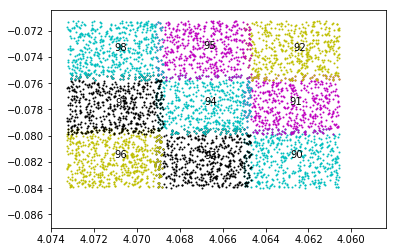

In [37]:
from cycler import cycler
meta = butlerISR.queryMetadata('postISRCCD', ['visit', 'detector'])
fig = plt.figure()
fig, ax  = plt.subplots(nrows=1)
ax.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) +
                   cycler('lw', [1, 2, 3, 4]))
plt.gca().invert_xaxis()
for visit, det in meta:
    #print (visit,det)
    if visit == 9006001:
        img = butlerISR.get('postISRCCD', dataId={'visit':visit, 'detector':det})
        gaiaCat = makeSourceCat(img.getBBox(), img.getWcs(), refObjLoader)
        xcen = gaiaCat['slot_Centroid_x']
        ycen = gaiaCat['slot_Centroid_y']
        ra = gaiaCat['coord_ra']
        dec = gaiaCat['coord_dec']
        plt.text(ra.mean(), dec.mean(), "{}".format(det))
        plt.scatter(ra,dec,s=1)

In [38]:
gaiaCat = makeSourceCat(raw.getBBox(), raw.getWcs(), refObjLoader)
xcen = gaiaCat['slot_Centroid_x']
ycen = gaiaCat['slot_Centroid_y']

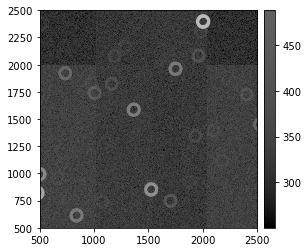

In [39]:
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(raw[500:2500,500:2500])

In [40]:
defocalState = 'intra'
detector = "R22_S22"
templateType = "model"
donutImgSize = 140
template = createTemplateImage(defocalState, detector, [[2000., 2000.]], templateType, donutImgSize)
kernelImage = lsst.afw.image.ImageD(template)

In [41]:
#correlate image
corr_exp = correlateExposureWithImage(raw, kernelImage, fft=True)

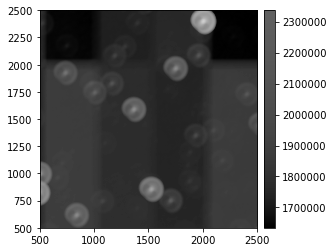

In [42]:
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(corr_exp[500:2500,500:2500])

In [43]:
#Run detection and measure on the correlated image using the simple PSF
#NOTE should look at which centroid is run to see if there are better ones
psf_array = gkern(l=11, sig=2.5)
#psf_array = gkern(l=5, sig=0.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

#Use DM tasks to run: detection, measure using the simple PSF (no deblending)
#From Merlin: It's usually a good idea to construct all Tasks before using any of them, mostly
# to define the full schema of any catalogs we'll produce up front.

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue =30   # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
configDetection.minPixels = 1000
#configDetection.minPixels = 10
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image 
from copy import deepcopy
exposure = deepcopy(corr_exp)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

Number of detected sources 20


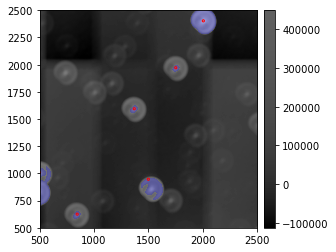

In [44]:
xcen = catalog['slot_Centroid_x']
ycen = catalog['slot_Centroid_y']
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exposure[500:2500,500:2500])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _x, _y, size=10, ctype='red')
print ('Number of detected sources {}'.format(len(xcen)))

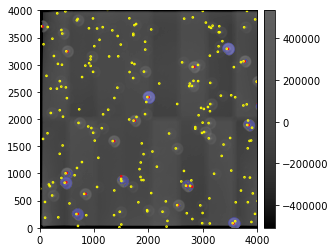

In [45]:
# Overlay x and y Gaia positions (from phosim WCS)
#Create a BBOX for the image and extract the Gaia catalog for that BBox and WCS
gaiaCat = makeSourceCat(exposure.getBBox(), exposure.getWcs(), refObjLoader)
xcen = catalog['slot_Centroid_x']
ycen = catalog['slot_Centroid_y']

fluxLimit = 100000
xcenG = gaiaCat['slot_Centroid_x'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
ycenG = gaiaCat['slot_Centroid_y'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exposure[0:4000,0:4000])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _x, _y, size=15, ctype='red')

for _x, _y in zip(xcenG, ycenG):
   afw_display.dot('o', _x, _y, size=15, ctype='yellow')

In [46]:
## match and fit wcs using AstrometryTask (notes from Merlin)
astromConfig = AstrometryTask.ConfigClass()
# Pick your retarget here if necessary
# astromConfig.wcsFitter.retarget(FitAffineWcsTask)
# astromConfig.wcsFitter.retarget(FitTanSipWcsTask)
# astromConfig.referenceSelector.doMagLimit = False
#    You probably *do* want to do a mag limit, because your donuts are
#    unlikely to go as deep as GAIA, and if you have too much choice the matcher
#    will always succeed, but finding false matches with huge scatter.
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_rp_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.99
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

# this is a bit sleazy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now
referenceFilterName = 'phot_rp_mean'
defineFilter(referenceFilterName, 656.28)
referenceFilter = afwImage.filter.Filter(referenceFilterName)
exposure.setFilter(referenceFilter)

solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=exposure,)

In [47]:
print (exposure.getWcs())
print (exposure.getWcs().getCdMatrix())

FITS standard SkyWcs:
Sky Origin: (233.237736, -4.217151)
Pixel Origin: (1954.52, 1737.15)
Pixel Scale: 0.200181 arcsec/pixel
[[ 8.29734824e-08  5.55687138e-05]
 [ 5.56426800e-05 -7.18435501e-08]]


In [48]:
#original phosim WCS
print (raw.getWcs())
print (raw.getWcs().getCdMatrix())

FITS standard SkyWcs:
Sky Origin: (233.017336, -4.447088)
Pixel Origin: (-2209.5, -2219.5)
Pixel Scale: 0.2 arcsec/pixel
[[-3.40179666e-21  5.55555556e-05]
 [ 5.55555556e-05  3.40179666e-21]]


In [49]:
results.scatterOnSky.asArcseconds()

0.5616307311072176

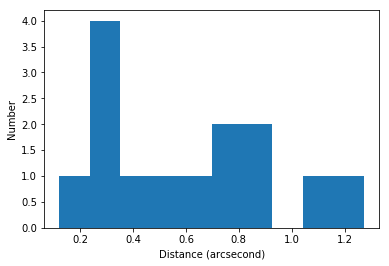

In [50]:
plotDistances(results.matches)

In [51]:
#try to get x y from ref catalog given a wcs
solvedPositions = refObjLoader.loadPixelBox(bbox=exposure.getBBox(), wcs=exposure.getWcs(), 
                                            filterName="phot_rp_mean")
solvedRefCat = solvedPositions.refCat
solvedRefCat.asAstropy()[0:5]

id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,astrometric_excess_noise,phot_variable_flag,centroid_x,centroid_y,hasCentroid
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,rad,rad,d,rad,rad,rad / yr,rad / yr,,rad,rad,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,bool,float64,float64,bool,float64,str52,float64,float64,bool
4401738602431223424,4.072645517940001,-0.07459519223760304,83152.75220144483,64943.022886354796,113527.26634602393,277.089333381601,2469.636948945306,4117.205864960953,1.5378188e-09,1.7619052e-09,57205.87440946643,-2.564631006115402e-08,-1.608615997617428e-08,2.9733207e-09,3.2828489e-09,False,1.5615759800310987e-09,1.5896062726020796e-09,False,0.0,NOT_AVAILABLE,922.1326663923342,3665.0916447544832,True
4401788733289591936,4.072840135419077,-0.07274251655148076,118787.01623664229,69682.18069618866,202482.33620853504,410.61135803479795,3851.6560052716877,4317.202499738334,3.408977e-09,4.558628e-09,57205.87440946643,0.0,0.0,0.0,0.0,False,0.0,0.0,False,0.6427078578810088,NOT_AVAILABLE,2838.9933664081777,3865.758807879527,True
4401785915790994432,4.072028432967247,-0.07382933596910414,192882.55628151254,84044.81360768399,381363.3208470571,382.2582221171711,2753.7795985742237,3587.2622525588704,8.7263985e-10,9.617822e-10,57205.87440946643,2.2474416518054377e-08,4.145785226307913e-09,1.6508626e-09,1.7994861e-09,False,3.766808940000308e-09,9.413139973800367e-10,False,0.19737783278017487,NOT_AVAILABLE,1719.1082926456622,3033.0661896903384,True
4401789214325980544,4.072714735365061,-0.07169287927007433,29545.420921988607,11323.721529063883,63722.47604706842,349.79545837101006,3274.2199866911087,2935.6651790690053,1.0365936e-08,1.5677255e-08,57205.87440946643,0.0,0.0,0.0,0.0,False,0.0,0.0,False,1.7021639369466717,NOT_AVAILABLE,3924.285938738104,3739.3449530642065,True
4401785537833840256,4.072325977350805,-0.07449943877921102,105356.79304409427,57616.4908247517,190548.31132261315,366.04665584554374,2402.354451785629,3511.9322216437417,1.3243195e-09,1.496024e-09,57205.87440946643,-3.03606399594439e-08,-2.7853602545616006e-08,2.604258e-09,2.9028013e-09,False,1.8941511995785987e-09,1.4180785866005793e-09,False,0.414902747086968,NOT_AVAILABLE,1024.0696131176305,3338.0930034500607,True


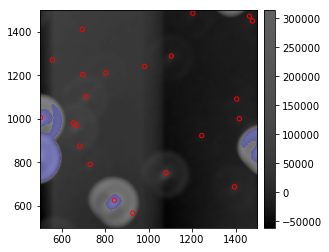

In [52]:
xcen = solvedRefCat['centroid_x']
ycen = solvedRefCat['centroid_y']

afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exposure[500:1500,500:1500])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _x, _y, size=10, ctype='red')

In [60]:
#detect donuts using ts code
from copy import deepcopy
exposure = deepcopy(raw)

from lsst.ts.wep.bsc.DonutDetector import DonutDetector
from lsst.ts.wep.cwfs.TemplateUtils import createTemplateImage
overlapDistance = 10
defocalState = 'intra'
detector = "R22_S22"
templateType = "model"
donutImgSize = 140
template = createTemplateImage(defocalState, detector, [[2000., 2000.]], templateType, donutImgSize)
donut_detect = DonutDetector(template)
donut_df = donut_detect.detectDonuts(exposure, overlapDistance)

/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Number of detected sources 27


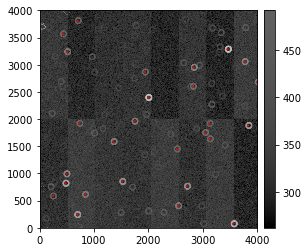

In [61]:
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
print ('Number of detected sources {}'.format(len(donut_df['x_center'])))
afw_display.mtv(exposure[0:4000,0:4000])
for _x, _y in zip(donut_df['x_center'], donut_df['y_center']):
   afw_display.dot('o', _x, _y, size=10, ctype='red')

In [62]:
# Create a source catalog to match against gaia
from lsst.geom import Point2D
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)

sourceCat = afwTable.SourceCatalog(sourceSchema)
sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
sourceIdKey = sourceSchema["id"].asKey()
sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

#populate source catalog with objects from reference catalog
sourceCat.reserve(len(donut_df['x_center']))
#NOTE TRANSPOSE
for i,(_x,_y) in enumerate(zip(donut_df['x_center'], donut_df['y_center'])):
    src = sourceCat.addNew()
    src.set(sourceIdKey, i)
    
    src.set(sourceCentroidKey, Point2D(_x, _y))
    src.set(sourceInstFluxKey, 15.)
    src.set(sourceInstFluxErrKey, 15./100)
print (len(donut_df['x_center']))

27


In [63]:
sourceCat.asAstropy()[0:5]

id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape

In [64]:
%%time 
#run solver - make sure we reinitialize the CCD incase WCS is bad
from copy import deepcopy
exposure = deepcopy(raw)

astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.doMagLimit = True
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_rp_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.99
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 3
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 10

# this is a bit sleazy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now
referenceFilterName = 'phot_rp_mean'
defineFilter(referenceFilterName, 656.28)
referenceFilter = afwImage.filter.Filter(referenceFilterName)
exposure.setFilter(referenceFilter)

solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=sourceSchema,)
results = solver.run(sourceCat=sourceCat, exposure=exposure,)

CPU times: user 16.1 s, sys: 1.64 s, total: 17.7 s
Wall time: 1.19 s


/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [65]:
results.scatterOnSky.asArcseconds()

0.029357061481192815

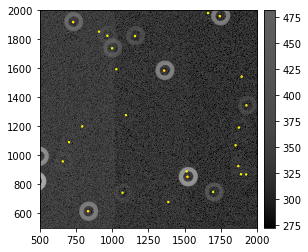

In [66]:
# Overlay x and y Gaia positions (from phosim WCS)
#Create a BBOX for the image and extract the Gaia catalog for that BBox and WCS
gaiaCat = makeSourceCat(exposure.getBBox(), exposure.getWcs(), refObjLoader)

fluxLimit = 100000
xcenG = gaiaCat['slot_Centroid_x'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
ycenG = gaiaCat['slot_Centroid_y'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exposure[500:2000,500:2000])
for _x, _y in zip(donut_df['x_center'], donut_df['y_center']):
   afw_display.dot('o', _x, _y, size=5, ctype='red')

for _x, _y in zip(xcenG, ycenG):
   afw_display.dot('o', _x, _y, size=5, ctype='yellow')